In [81]:
import numpy as np
from scipy.fft import dct, idct
from scipy.fft import dctn, idctn
from sympy import sin, cos
from sympy.abc import x, y
import cv2
import matplotlib.pyplot as plt
from skimage import morphology
from skimage.restoration import unwrap_phase
from skimage import data, img_as_float, color, exposure
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage
import skimage

import os

In [83]:
def normalize(image):            return (image/255 - 0.5)*2
def to_image(normalized_image):  return ((normalized_image/2 + 0.5) * 255).astype(np.uint8)

In [84]:
# Load and read recorded hologram and reference beam into numpy
obj_str = os.path.join(os.path.expanduser('~'), "Downloads", "obj1.tif")
ref_str = os.path.join(os.path.expanduser('~'), "Downloads", "ref1.tif")

def normalize(image):            return (image/255 - 0.5)*2

holo = cv2.imread(obj_str, 0)
holo = normalize(holo)

ref = cv2.imread(ref_str, 0)
ref = normalize(ref)

# Set the coordinates of the hologram and the reference beam
Ny, Nx = holo.shape
minN = min(Ny, Nx)
print(minN)

img = holo[:minN, :minN]
ref = ref[:minN, :minN]
Ny, Nx = img.shape

# Supression of the DC term using the recorded reference beam
# ref_root = np.sqrt(ref)
# imgH = (img - ref) / ref_root
# imgH[imgH == np.max(imgH)] = np.median(imgH)

imgH = img - np.mean(img)

norm_factor = np.mean(ref) / (np.mean(img)*ref)
imgH = img * norm_factor

# Define parameters
N = Nx
lambda_ = 488e-9 #wavelength
k = 2*np.pi/lambda_
dx = 1.12e-6 #pixel size
dy = dx
z = 8e-2 #z-distance
nx = np.arange(-N/2, N/2, dtype=float)
my = np.arange(-N/2, N/2, dtype=float)
w = 50e-6/2

# Determine the region of the observational plane
nF = w**2/(lambda_*z)
zz = (10*w**2)/lambda_

# Spatial coordinates x, y
x = nx*dx
y = my*dy
X, Y = np.meshgrid(x, y)

# Spectral sampling interval
dfx = 1/(N*dx)
dfy = 1/(N*dy)

# Spectral coordinates fx, fy
fx = nx*dfx
fy = my*dfy
Fx, Fy = np.meshgrid(fx, fy)

dmax = 4e-3

# Number of iterations
numIteration = 1
# The measured hologram amplitude is used for the an initial guess
input = imgH

# Creating initial complex-valued field distribution in the detector plane
phase = np.zeros((N, N), dtype=complex)
true_phase = phase
detField = imgH*np.exp(1j*phase)

# Creating wave propagation term
prop = np.exp((1j*2*np.pi*dmax)*np.sqrt((1/lambda_**2) - Fx**2 - Fy**2))

p = 0.01

detField = imgH * np.exp(-1j * true_phase)

# Fourier transform of the processed hologram with the DC term
FimgH = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(detField)))
logimg = np.log(np.abs(FimgH))
logimgmaxmin = (logimg - np.min(np.min(logimg))) / (np.max(np.max(logimg)) - np.min(np.min(logimg)))

# reconstruction of the transmission function, t
t = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(FimgH * prop)))
amp = np.abs(t)
phi = -np.angle(t)
absorptn = -np.log(amp)
UnimgH = unwrap_phase(phi)
amp = np.exp(-absorptn)

for ii in range(N):
    for jj in range(N):
        if absorptn[ii, jj] < 0:
            absorptn[ii, jj] = 0
            phi[ii, jj] = 0

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

Text(0.5, 1.0, 'Original Hologram')

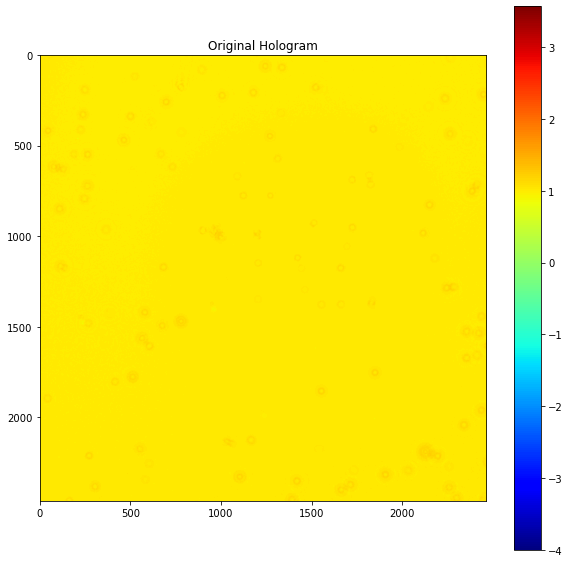

In [76]:
# displaying amplitude result
amp = np.exp(-absorptn)
#plt.figure(20)
plt.figure(figsize = (10,10))
plt.imshow(imgH, cmap='jet')
#plt.axis('square')
plt.colorbar()
plt.title('Original Hologram')

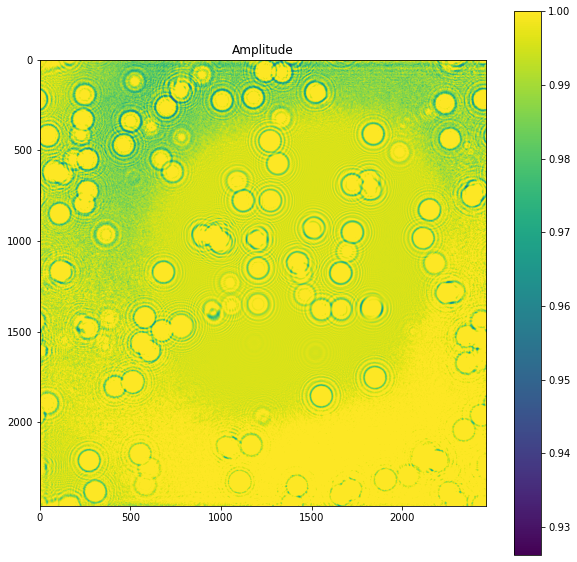

In [77]:
#amp = np.exp(-absorptn)
plt.figure(figsize = (10,10))
plt.imshow(amp)
plt.imsave('Amplitude.png', amp)
#plt.axis('square')
plt.colorbar()
plt.title('Amplitude')
plt.pause(p)

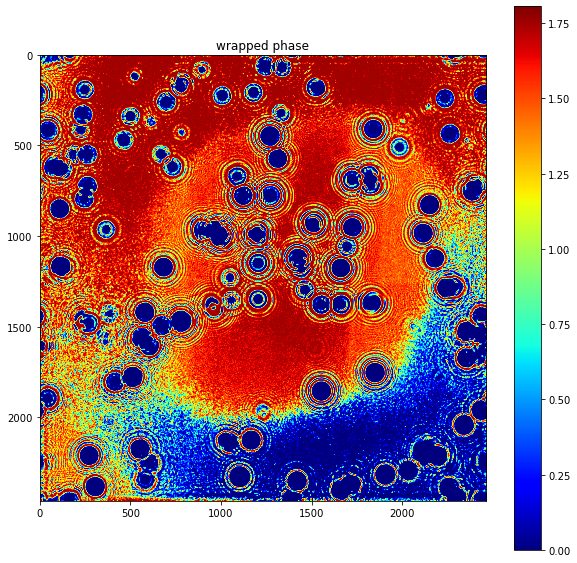

In [78]:
plt.figure(figsize = (10,10))
plt.imshow(phi, cmap='jet')
plt.imsave('WrappedPhase.png', phi, cmap = 'gray')
#plt.axis('square')
plt.colorbar()
plt.title('wrapped phase')
plt.pause(p)

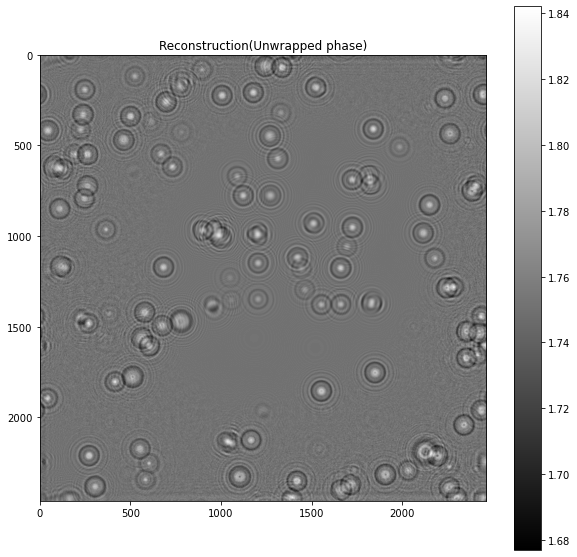

In [79]:
plt.figure(figsize = (10,10))
plt.imshow(UnimgH, cmap='gray')
plt.imsave('UnwrappedPhase.png', UnimgH, cmap = 'gray')
#plt.axis('square')
plt.colorbar()
plt.title('Reconstruction(Unwrapped phase)')
plt.pause(p)

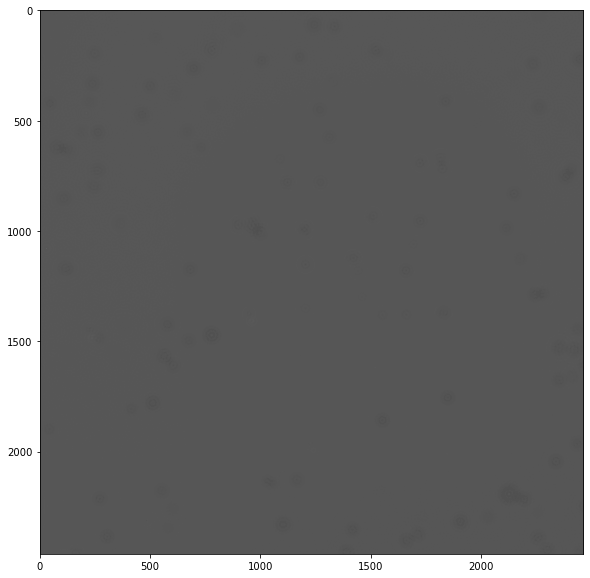

In [65]:
plt.figure(figsize = (10,10))
plt.imshow(UnimgH-imgH, cmap='gray')